In [1]:
import cv2
import itertools
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve,roc_auc_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

In [2]:
def save_pickle(variable,filename,folder):
    pickle_out=open(str(folder)+"/"+str(filename) + ".pickle","wb")
    pickle.dump(variable,pickle_out)
    pickle_out.close()
    
def load_pickle(filename,folder):
    return pickle.load(open(str(folder)+"/"+str(filename) + ".pickle","rb"))

In [3]:
def normalized_training_test_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        test_size=0.3,
                                                        stratify=y,
                                                        random_state=random_state)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, y_train, y_test

In [4]:
def PCA_fit(X):
    pca = PCA(n_components=None)
    pca.fit(X)
    eigenvalues=pca.explained_variance_
    explained_variance=pca.explained_variance_ratio_
    return eigenvalues,explained_variance

In [5]:
def PCA_plot(eigenvalues,explained_var):
    print("Eigenvalues:")
    print(eigenvalues)
    print()
    # Get explained variances
    print("Variances (Percentage):")
    print(explained_var * 100)
    print()
    plt.plot(np.cumsum(explained_var * 100))
    plt.xlabel("Number of components (Dimensions)")
    plt.ylabel("Explained variance (%)")
    plt.show()
    return

In [6]:
def PCA_transform(X_train,X_test):
    pca = PCA(0.9,random_state=random_state)
    X1 = pca.fit_transform(X_train)
    X2 = pca.transform(X_test)
    return pd.DataFrame(X1), pd.DataFrame(X2)

In [7]:
def logistic_tuner_model(X_train,X_test,y_train,y_test):
    
    stratified_kfold = StratifiedKFold(n_splits=5,
                                       random_state=random_state,
                                       shuffle=True)
    
    c_values = [100, 10, 1.0, 0.1, 0.01]
    solver=['saga', 'sag','newton-cg', 'lbfgs', 'liblinear']          
    
    param_grid = {'C':c_values,
                  'solver': solver}
    
    random_search = RandomizedSearchCV(LogisticRegression(random_state=random_state),
                                       param_distributions=param_grid,
                                       scoring='roc_auc',
                                       cv=stratified_kfold,
                                       n_jobs=-1,
                                       n_iter=20)
    
    random_result = random_search.fit(X_train, y_train)
    cv_results=random_result.cv_results_    
    y_predict=random_search.predict(X_test)
    y_preds=random_search.predict_proba(X_test)[:,1]
    cv_score = random_search.best_score_
    
    accuracy_table=pd.DataFrame((cv_results["split0_test_score"],
                               cv_results["split1_test_score"],
                               cv_results["split3_test_score"],
                               cv_results["split3_test_score"],
                               cv_results["split4_test_score"]))    
     
    return random_result,cv_results,cv_score,y_predict,y_test,accuracy_table,y_preds

In [8]:
def rf_tuner_model(X_train,X_test,y_train,y_test):
    
    stratified_kfold = StratifiedKFold(n_splits=5,
                                       random_state=random_state,
                                       shuffle=True)
    
    n_estimators=[200, 400, 600, 800]
    max_features = ['auto', 'sqrt', 'log2']
    max_depth=[4,8,12,16,20]
    criterion=['gini', 'entropy']
            
    param_grid = {'n_estimators':n_estimators,
                  'max_features':max_features,
                  'max_depth':max_depth,
                  'criterion':criterion}
    
    random_search = RandomizedSearchCV(RandomForestClassifier(random_state=random_state),
                                       param_distributions=param_grid,
                                       scoring='roc_auc',
                                       cv=stratified_kfold,
                                       n_jobs=-1, 
                                       n_iter=20)
    
    random_result = random_search.fit(X_train, y_train)
    cv_results=random_result.cv_results_    
    y_predict=random_search.predict(X_test)
    y_preds=random_search.predict_proba(X_test)[:,1]
    cv_score = random_search.best_score_
    
    accuracy_table=pd.DataFrame((cv_results["split0_test_score"],
                               cv_results["split1_test_score"],
                               cv_results["split3_test_score"],
                               cv_results["split3_test_score"],
                               cv_results["split4_test_score"])) 
     
    return random_result,cv_results,cv_score,y_predict,y_test,accuracy_table,y_preds

In [9]:
def svm_tuner_model(X_train,X_test,y_train,y_test):
    
    stratified_kfold = StratifiedKFold(n_splits=5,
                                       random_state=random_state,
                                       shuffle=True)
    
    kernel=['rbf','poly','sigmoid']
    c_values = [0.001,0.1,1,10,100,1000]
    gamma=[1000,100,10,1,0.1,0.01,0.001]
            
    param_grid = {'kernel':kernel,
                  'C':c_values,
                  'gamma':gamma}
    
    random_search = RandomizedSearchCV(svm.SVC(cache_size=500,probability=True,random_state=random_state),
                                       param_distributions=param_grid,
                                       scoring='roc_auc',
                                       cv=stratified_kfold,
                                       n_jobs=-1,
                                       n_iter=20)
    
    random_result = random_search.fit(X_train, y_train)
    cv_results=random_result.cv_results_    
    y_predict=random_search.predict(X_test)
    y_preds=random_search.predict_proba(X_test)[:,1]
    cv_score = random_search.best_score_
    
    accuracy_table=pd.DataFrame((cv_results["split0_test_score"],
                               cv_results["split1_test_score"],
                               cv_results["split3_test_score"],
                               cv_results["split3_test_score"],
                               cv_results["split4_test_score"])) 
     
    return random_result,cv_results,cv_score,y_predict,y_test,accuracy_table,y_preds

In [10]:
def classifier_analysis(classifier):
    
    print("Best model performance: %f using %s" % (classifier[0].best_score_, classifier[0].best_params_))
    best_score_index=classifier[1]["rank_test_score"][classifier[1]["rank_test_score"].min()]
    classifier_time=classifier[1]["mean_fit_time"][best_score_index]+classifier[1]["mean_score_time"][best_score_index]
    print('Model fit and testing time: ' + str(round(classifier_time,2)) +"seconds \n")
    
    means =classifier[1]['mean_test_score']
    stds =classifier[1]['std_test_score']
    params =classifier[1]['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    print('\nTraining Accuracy Score : ' +str(round(classifier[2]*100,2))+ "%")
    print('Test Accuracy Score : ' + str(round(accuracy_score(classifier[4],classifier[3], normalize = True)*100,2))+"%")

    figure, axis = plt.subplots(2,2,figsize=(15,15))
    
    accuracy_table=pd.DataFrame(classifier[5])
    tmeans,tstds,tmins,tmaxes=accuracy_table.mean(),accuracy_table.std(),accuracy_table.min(),accuracy_table.max()
    axis[0,0].errorbar(np.arange(20), tmeans, tstds, fmt='ok', lw=3)
    axis[0,0].errorbar(np.arange(20), tmeans, [tmeans - tmins, tmaxes - tmeans], fmt='ok', ecolor='gray', lw=1)
    axis[0,0].set_title("Cross Validation Boxplot",fontsize=16)
    axis[0,0].set_ylabel("Score Accuracy", fontsize=12)

    cf_matrix = confusion_matrix(classifier[4], classifier[3])
    axis[0,1].set_title("Test Confusion Matrix",fontsize=16)
    sns.heatmap(cf_matrix, cmap= "Blues",annot=True,ax=axis[0,1], fmt='g')
    axis[0,1].set_xlabel('Predicted', fontsize=12)
    axis[0,1].set_ylabel('True', fontsize=12)
    
    fpr, tpr, _ = roc_curve(classifier[4],  classifier[6])
    auc = round(roc_auc_score(classifier[4], classifier[6]), 4)
    axis[1,0].set_title("Test ROC Curve",fontsize=16)
    axis[1,0].plot(fpr,tpr,'b')
    axis[1,0].set_ylabel('TPR: True Positive Rate')
    axis[1,0].set_ylim(0, 1)
    axis[1,0].set_xlabel('FPR: False Positive Rate')
    axis[1,0].set_xlim(0, 1)
    
    far,frr=fpr,1-tpr
    err= min(np.argwhere(np.diff(np.sign(far - frr))).flatten())
    xval=np.linspace(0,1,num=len(far))
    axis[1,1].set_title("Test FRR FAR Curve",fontsize=16)
    axis[1,1].plot(xval,far,'k',label ='FAR')
    axis[1,1].plot(xval,frr,'b',label ='FRR')
    axis[1,1].scatter(xval[err], far[err],s=100)
    axis[1,1].text(xval[err]+0.05,far[err],"Equal Error Rate ~" + str(round(far[err],4)),fontsize = 10)
    axis[1,1].legend(loc ="best")
    axis[1,1].set_ylabel('Error Rate')
    axis[1,1].set_ylim(0, 1)
    axis[1,1].axes.get_xaxis().set_visible(False)
    plt.show()
    return

In [11]:
#loading data
random_state=42
X_data_file,y_data_file,data_folder="data_for_classification","y","data"
X_data=load_pickle(X_data_file,data_folder)
y_data=load_pickle(y_data_file,data_folder)

In [12]:
X=pd.DataFrame(X_data)
y=pd.DataFrame(y_data)

In [13]:
pca_results=PCA_fit(X)
PCA_file,results_folder="pca_result","results"
#pca_results=load_pickle(PCA_file,results_folder)
save_pickle(pca_results,PCA_file,results_folder)

Eigenvalues:
[1.83834921e+07 1.44369163e+07 1.19291848e+07 ... 1.09486329e-24
 1.07703720e-24 8.74776217e-26]

Variances (Percentage):
[4.33092864e+00 3.40116306e+00 2.81037181e+00 ... 2.57936565e-31
 2.53736951e-31 2.06086708e-32]



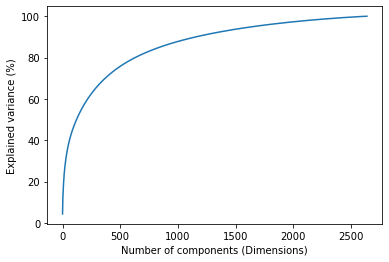

In [14]:
PCA_plot(pca_results[0],pca_results[1])

In [15]:
X_train,X_test,y_train,y_test=normalized_training_test_data(X,y)
X_train,X_test=PCA_transform(X_train,X_test)

In [16]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101
0,-36.094334,16.512564,17.622886,52.763576,-20.348342,-36.716033,-3.828115,-13.503619,-19.368143,-0.641070,...,1.946971,4.020147,9.674754,-3.432281,-1.977961,4.082172,1.428405,5.481869,-0.513490,4.106142
1,46.250745,34.825410,-66.775996,30.155193,2.185558,-62.769614,58.290470,2.963363,17.630164,-2.441376,...,-3.476533,-2.178034,1.676844,-3.819513,-4.493782,4.163675,0.246159,-7.010392,-7.707667,9.278189
2,-46.691305,5.790800,-32.869932,-6.683673,30.674598,18.316730,26.836368,-22.668216,-12.079661,22.825260,...,-7.203258,0.632935,1.680331,0.822252,0.278041,7.999410,1.493510,2.788368,-1.405982,3.879929
3,-29.822042,-64.112761,9.428365,2.695150,-9.995980,-19.227722,4.535243,-10.367908,-13.376214,-8.678666,...,-0.344356,-2.844422,1.672506,1.091811,2.780254,1.770009,-1.440213,-3.230118,-1.228532,2.833270
4,-21.786279,-2.131246,-29.051156,-30.441807,23.082817,-17.359088,17.166387,-65.745675,-2.372181,12.221968,...,0.094261,7.290500,-7.991000,0.461289,-3.372579,-4.651415,2.831565,0.387899,-1.702901,8.560448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,-57.631790,-51.365769,3.491117,-8.190602,-25.764734,-4.867267,-26.467441,-7.460104,3.769816,-38.763011,...,-4.376467,1.011656,-3.746547,6.402974,-2.428546,-1.137838,-7.470571,0.756841,-2.418487,0.496454
1844,-59.481756,-4.116613,10.417020,89.298497,-10.464589,28.346076,-34.250257,15.145490,54.689233,15.609983,...,-3.320902,-2.513961,1.270083,0.452157,3.109351,-6.992545,-4.629761,3.439640,0.997040,4.574663
1845,-9.832677,-15.975168,79.126600,28.595277,-26.002782,7.227955,10.275377,28.305757,-11.035615,-14.763165,...,7.014016,0.892653,3.683396,-3.701181,-1.590107,-3.815826,2.083755,4.589791,3.947216,7.285975
1846,147.048629,-6.452312,-45.513433,26.772949,-40.993496,-4.391937,-0.910408,6.234073,42.445681,-38.654521,...,-0.946835,-4.698472,-0.519008,-2.612656,3.266145,0.147714,0.314145,-1.388810,-0.980483,-0.528473


In [17]:
logistic_filename,svm_filename,rforest_filename="logistic_result","svm_result","rforest_result"

In [18]:
#logistic_result=load_pickle(logistic_filename,results_folder)
#svm_result=load_pickle(svm_filename,results_folder)
#rforest_result=load_pickle(rforest_filename,results_folder)

In [19]:
#training model
logistic_result=logistic_tuner_model(X_train,X_test,y_train,y_test)
save_pickle(logistic_result,logistic_filename,results_folder)

Best model performance: 0.758255 using {'solver': 'saga', 'C': 0.01}
Model fit and testing time: 2.12seconds 

0.739864 (0.013334) with: {'solver': 'newton-cg', 'C': 0.01}
0.725795 (0.015040) with: {'solver': 'newton-cg', 'C': 100}
0.729141 (0.014419) with: {'solver': 'lbfgs', 'C': 100}
0.757710 (0.014814) with: {'solver': 'saga', 'C': 0.1}
0.740182 (0.013261) with: {'solver': 'liblinear', 'C': 0.01}
0.733132 (0.014107) with: {'solver': 'lbfgs', 'C': 0.1}
0.713366 (0.013833) with: {'solver': 'liblinear', 'C': 10}
0.751181 (0.013591) with: {'solver': 'sag', 'C': 0.01}
0.750589 (0.013578) with: {'solver': 'sag', 'C': 1.0}
0.709345 (0.013751) with: {'solver': 'liblinear', 'C': 100}
0.757686 (0.014782) with: {'solver': 'saga', 'C': 1.0}
0.739924 (0.013148) with: {'solver': 'lbfgs', 'C': 0.01}
0.757680 (0.014775) with: {'solver': 'saga', 'C': 100}
0.758255 (0.014506) with: {'solver': 'saga', 'C': 0.01}
0.728678 (0.014495) with: {'solver': 'lbfgs', 'C': 10}
0.757680 (0.014775) with: {'solver

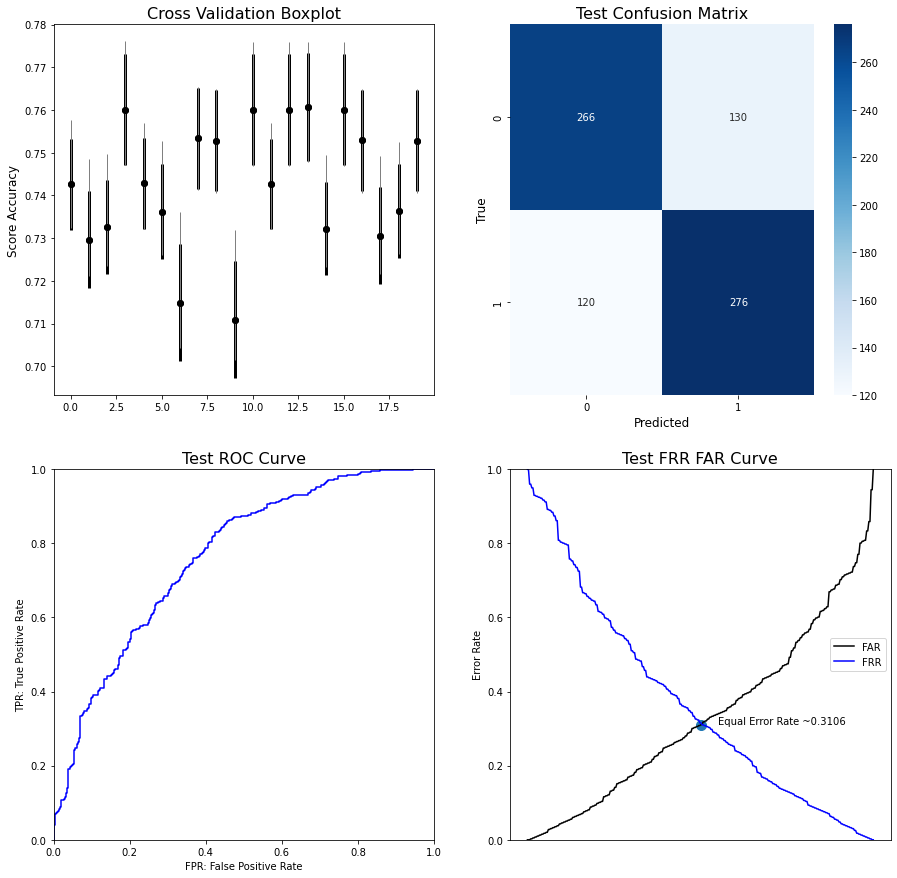

In [20]:
classifier_analysis(logistic_result)

In [21]:
svm_result=svm_tuner_model(X_train,X_test,y_train,y_test)
save_pickle(svm_result,svm_filename,results_folder)

Best model performance: 0.924584 using {'kernel': 'poly', 'gamma': 0.1, 'C': 10}
Model fit and testing time: 22.97seconds 

0.475437 (0.025329) with: {'kernel': 'sigmoid', 'gamma': 0.01, 'C': 0.1}
0.502165 (0.001083) with: {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
0.564948 (0.011046) with: {'kernel': 'rbf', 'gamma': 0.001, 'C': 0.1}
0.924578 (0.015833) with: {'kernel': 'poly', 'gamma': 0.001, 'C': 1}
0.608408 (0.011950) with: {'kernel': 'sigmoid', 'gamma': 100, 'C': 0.001}
0.502165 (0.001083) with: {'kernel': 'rbf', 'gamma': 10, 'C': 1}
0.924578 (0.015833) with: {'kernel': 'poly', 'gamma': 0.001, 'C': 0.001}
0.478616 (0.010280) with: {'kernel': 'sigmoid', 'gamma': 100, 'C': 10}
0.502165 (0.001083) with: {'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
0.481007 (0.013907) with: {'kernel': 'sigmoid', 'gamma': 1000, 'C': 10}
0.480525 (0.015597) with: {'kernel': 'sigmoid', 'gamma': 0.001, 'C': 1000}
0.924584 (0.015835) with: {'kernel': 'poly', 'gamma': 0.1, 'C': 10}
0.502165 (0.001083) with: {'ker

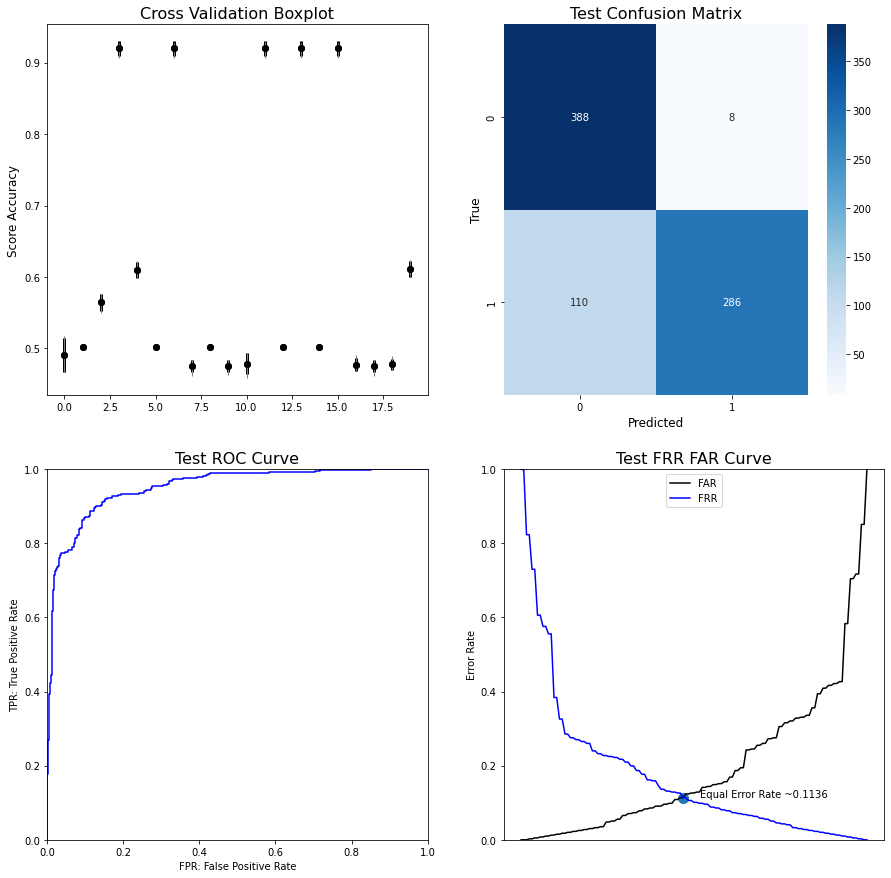

In [22]:
classifier_analysis(svm_result)

In [41]:
rforest_result=rf_tuner_model(X_train,X_test,y_train,y_test)
save_pickle(rforest_result,rforest_filename,results_folder)

Best model performance: 0.743145 using {'n_estimators': 800, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'entropy'}
Model fit and testing time: 22.07seconds 

0.692972 (0.019979) with: {'n_estimators': 400, 'max_features': 'auto', 'max_depth': 16, 'criterion': 'gini'}
0.626906 (0.029326) with: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy'}
0.646862 (0.016411) with: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 12, 'criterion': 'gini'}
0.631030 (0.026545) with: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 12, 'criterion': 'entropy'}
0.634784 (0.037606) with: {'n_estimators': 400, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'gini'}
0.681696 (0.020246) with: {'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': 12, 'criterion': 'gini'}
0.730985 (0.014194) with: {'n_estimators': 600, 'max_features': 'auto', 'max_depth': 4, 'criterion': 'gini'}
0.596681 (0.025997) with: {'n_estimators': 200, 'max_feat

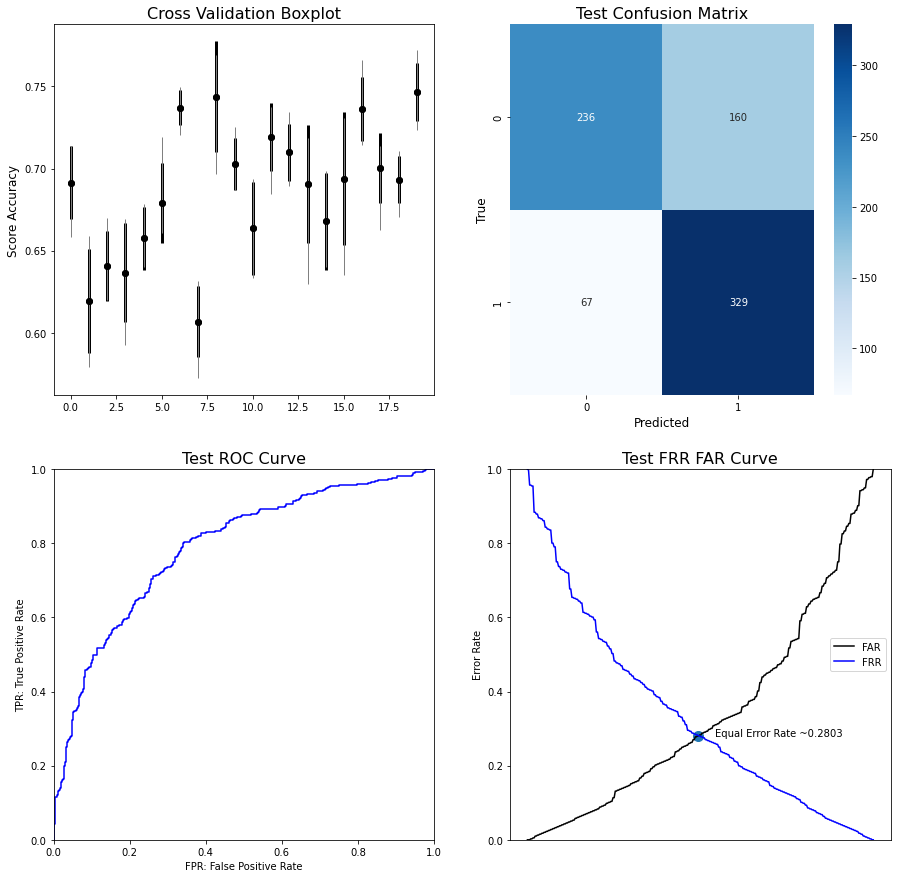

In [42]:
classifier_analysis(rforest_result)